
## Libraries


In [1]:

import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:

import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader



In [3]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


In [8]:

## !pip install onnxmltools
## !pip install onnxruntime
## !pip install skl2onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.4 MB/s eta 0:00:00


In [9]:

import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType



## Parameters


In [10]:

batch_size    = 64
learning_rate = 0.001
N_Epochs      = 1000

epsilon = 0.0001



## Read data


In [11]:

## from google.colab import drive

## drive.mount('/content/drive')


Mounted at /content/drive


In [13]:

path_data = '/content/drive/MyDrive/Fall 2025/ITS 520/Part 2/HW3/Classification/weather_classification_data.csv'

weather_data = pd.read_csv( path_data )


In [14]:

weather_data


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


In [47]:

from sklearn.preprocessing import LabelEncoder

encoders = {}
label_cols = ['Cloud Cover', 'Season', 'Location', 'Weather Type']

for col in label_cols:
    encoders[col] = LabelEncoder()
    weather_data[col] = encoders[col].fit_transform(weather_data[col])


In [50]:

print(list(zip(encoder.classes_, encoder.transform(encoder.classes_))))


[('Cloudy', np.int64(0)), ('Rainy', np.int64(1)), ('Snowy', np.int64(2)), ('Sunny', np.int64(3))]


In [52]:

weather_data


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1,1
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1,0
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2,3
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0,3
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2,1
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,2,1003.15,1,2,1.0,2,1
13196,-1.0,76,3.5,23.0,1,1067.23,1,3,6.0,0,2
13197,30.0,77,5.5,28.0,2,1012.69,3,0,9.0,0,0
13198,3.0,76,10.0,94.0,2,984.27,0,3,2.0,1,2


In [53]:

headers_list = weather_data.columns.values.tolist()

headers_list


['Temperature',
 'Humidity',
 'Wind Speed',
 'Precipitation (%)',
 'Cloud Cover',
 'Atmospheric Pressure',
 'UV Index',
 'Season',
 'Visibility (km)',
 'Location',
 'Weather Type']


## Data Analysis

* Correlation matrix


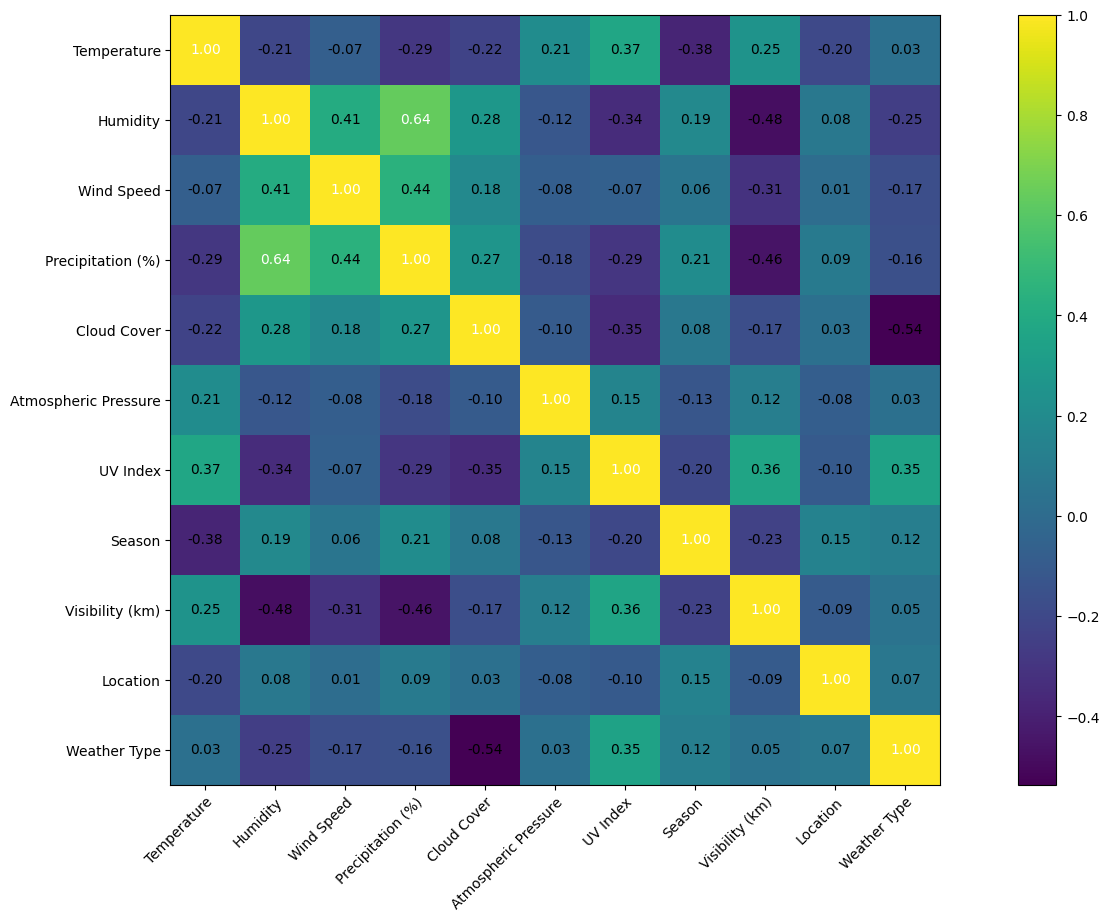

In [54]:

cm = np.corrcoef(   weather_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show()



## Process Data


In [55]:

## Convert Pandas to Numpy

weather_data_np = weather_data.to_numpy()


In [56]:

weather_data_np


array([[14. , 73. ,  9.5, ...,  3.5,  1. ,  1. ],
       [39. , 96. ,  8.5, ..., 10. ,  1. ,  0. ],
       [30. , 64. ,  7. , ...,  5.5,  2. ,  3. ],
       ...,
       [30. , 77. ,  5.5, ...,  9. ,  0. ,  0. ],
       [ 3. , 76. , 10. , ...,  2. ,  1. ,  2. ],
       [-5. , 38. ,  0. , ..., 10. ,  2. ,  1. ]])

In [57]:

weather_data_np.shape


(13200, 11)

In [58]:

X = weather_data_np[:, :-1]   # all columns except last

y = weather_data_np[:, 10:11]    # only last column


In [59]:

y


array([[1.],
       [0.],
       [3.],
       ...,
       [0.],
       [2.],
       [1.]])

In [60]:

y = y.astype(int)


In [61]:

y


array([[1],
       [0],
       [3],
       ...,
       [0],
       [2],
       [1]])

In [62]:

the_set = np.unique(y)

the_set


array([0, 1, 2, 3])

In [63]:

len(  the_set  )


4

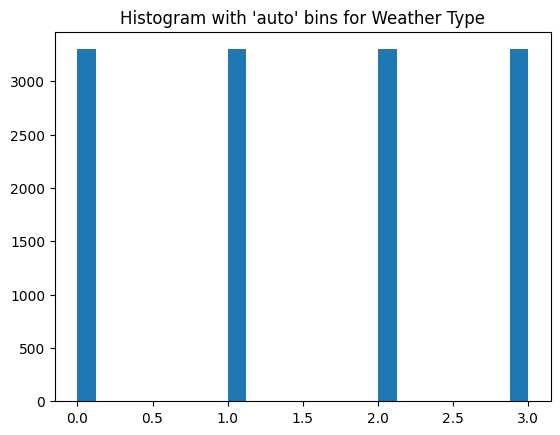

In [64]:

_ = plt.hist(y, bins='auto')

plt.title("Histogram with 'auto' bins for Weather Type")

plt.show()


In [65]:

print(X.shape)

print(y.shape)


(13200, 10)
(13200, 1)


In [66]:

random_seed = int( random.random() * 100 )


In [67]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [68]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(10560, 10)
(2640, 10)
(10560, 1)
(2640, 1)


In [69]:

X_test.dtype


dtype('float64')

In [70]:

y_test.dtype


dtype('int64')


## Fix in case float64 error


In [71]:

## fix data type

X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.int64 )
y_test  = y_test.astype(   np.int64 )


In [72]:

X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)



## Normalization


In [73]:

x_means      = X_train_tr.mean(0, keepdim=True )

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon


In [74]:

x_means


tensor([[  19.0722,   68.7205,    9.8173,   53.6596,    1.9912, 1006.0714,
            4.0175,    1.8529,    5.4652,    1.0934]])

In [75]:

x_deviations


tensor([[17.3494, 20.2905,  6.9305, 31.9572,  1.0125, 37.2323,  3.8623,  1.1661,
          3.3940,  0.7948]])


## Create the DataLoader


In [76]:

X_train.shape[0]


10560

In [77]:

weather_train_list = [ (X_train_tr[i], y_train_tr[i].item()) for i in range(X_train.shape[0]) ]

weather_test_list  = [ (X_test_tr[i],  y_test_tr[i].item())  for i in range(X_test.shape[0]) ]


In [78]:

weather_train_list[:3]


[(tensor([-4.0000e+00,  6.4000e+01,  8.5000e+00,  3.5000e+01,  3.0000e+00,
           1.1358e+03,  1.0000e+00,  3.0000e+00,  1.5500e+01,  1.0000e+00]),
  2),
 (tensor([ -8.0000,  75.0000,   7.5000,  58.0000,   2.0000, 993.8300,   0.0000,
            3.0000,   1.5000,   2.0000]),
  2),
 (tensor([4.5000e+01, 1.0200e+02, 9.0000e+00, 8.6000e+01, 3.0000e+00, 1.0115e+03,
          7.0000e+00, 1.0000e+00, 8.5000e+00, 2.0000e+00]),
  3)]

In [79]:

train_dl = torch.utils.data.DataLoader(weather_train_list, batch_size=batch_size, shuffle=True)


In [80]:

X_test.shape[0]


2640

In [81]:

all_test_data = X_test.shape[0]

test_dl  = torch.utils.data.DataLoader(weather_test_list,  batch_size=all_test_data, shuffle=True)


In [82]:

train_dl



## Neural Network Architectures


In [83]:

## MLP

class MLP_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(10, 16)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(16, 4)
        self.act2    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)


    ## perform inference
    def forward(self, x):

        x      = (x - self.x_means) / self.x_deviations

        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        y_pred = self.act2(x)

        return y_pred


In [84]:

## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(10, 32)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(16, 4)
        self.act3    = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    ## perform inference
    def forward(self, x):

        x      = (x - self.x_means) / self.x_deviations

        x      = self.linear1(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)

        return y_pred


## Training Loop

In [93]:

def training_loop( N_Epochs, model, loss_fn, opt, train_dl  ):

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:

            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch % 50 == 0:
            print(epoch, "loss=", loss)



## Train and Evaluate Models


In [94]:

models = {
    "MLP": MLP_Net(x_means, x_deviations),
    "Deep": DL_Net(x_means, x_deviations)
}


In [95]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))


In [96]:

results = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")

    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    training_loop(N_Epochs, model, loss_fn, opt, train_dl)

    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tr)
        y_pred_classes = torch.argmax(y_pred_test, dim=1)

    print(f"\nResults for {name}:")
    print_metrics_function(y_test_tr.numpy(), y_pred_classes.numpy())

    acc = accuracy_score(y_test_tr.numpy(), y_pred_classes.numpy())
    f1 = f1_score(y_test_tr.numpy(), y_pred_classes.numpy(), average='weighted')
    results[name] = {"accuracy": acc, "f1": f1}



Training MLP model...
0 loss= tensor(1.1348, grad_fn=<NllLossBackward0>)
50 loss= tensor(0.8003, grad_fn=<NllLossBackward0>)
100 loss= tensor(0.8985, grad_fn=<NllLossBackward0>)
150 loss= tensor(0.8544, grad_fn=<NllLossBackward0>)
200 loss= tensor(0.8680, grad_fn=<NllLossBackward0>)
250 loss= tensor(0.9157, grad_fn=<NllLossBackward0>)
300 loss= tensor(0.8194, grad_fn=<NllLossBackward0>)
350 loss= tensor(0.8878, grad_fn=<NllLossBackward0>)
400 loss= tensor(0.7778, grad_fn=<NllLossBackward0>)
450 loss= tensor(0.8052, grad_fn=<NllLossBackward0>)
500 loss= tensor(0.8062, grad_fn=<NllLossBackward0>)
550 loss= tensor(0.8374, grad_fn=<NllLossBackward0>)
600 loss= tensor(0.8634, grad_fn=<NllLossBackward0>)
650 loss= tensor(0.8659, grad_fn=<NllLossBackward0>)
700 loss= tensor(0.8303, grad_fn=<NllLossBackward0>)
750 loss= tensor(0.7880, grad_fn=<NllLossBackward0>)
800 loss= tensor(0.7762, grad_fn=<NllLossBackward0>)
850 loss= tensor(0.8844, grad_fn=<NllLossBackward0>)
900 loss= tensor(0.7911, g

## Deploy PyTorch Model

In [97]:

model = DL_Net(x_means, x_deviations)

dummy_input = torch.randn(1, 10)

input_names  = ["input1"]
output_names = ["output1"]

torch.onnx.export(
        model,
        dummy_input,
        "/content/drive/MyDrive/Fall 2025/ITS 520/Part 2/HW3/Classification/DLNet_WeatherData.onnx",
        verbose=False,
        input_names = input_names,
        output_names = output_names

)


/tmp/ipython-input-196848325.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
